In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import (BatchNormalization, Input, Dense, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = math.pi
maxval = 1e9
minval = 1e-9
a = 0.0
b = 1.01

In [2]:
train_df = pd.read_csv('./train1Dy_df.csv')
test_df = pd.read_csv('./test1Dy_df.csv')
print(train_df.shape, test_df.shape)

(1991564, 16) (125498, 16)


In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-local','y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-local','y-midplane','cotBeta']).values

y_train = inverse_cot(abs(train_df['cotBeta'].values))*2/pi
y_test = inverse_cot(abs(test_df['cotBeta'].values))*2/pi

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_7520/2672626872.py:2: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1/cota)


In [5]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

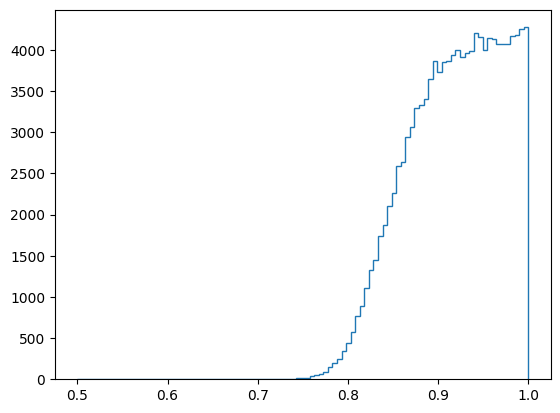

In [6]:
plt.hist(y_test,bins=np.linspace(0.5,1,100), histtype = 'step');

In [7]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def log_beta(x, alpha, beta, a=0.0, b=1.01):
    # x in (0, 1), alpha > 0, beta > 0, a < x < b
    return (alpha - 1.0)*tf.math.log(x - a) + (beta - 1.0)*tf.math.log(b - x) \
            - tf.math.lgamma(alpha) - tf.math.lgamma(beta) + tf.math.lgamma(alpha + beta) \
            - (alpha + beta - 1.)*tf.math.log(b - a)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    NLL = -1*log_beta(y, alpha, beta)
    return tf.keras.backend.sum(NLL,axis=1)

In [8]:
def CreateBatNaN(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("relu", name="relu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("relu", name="relu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateBatNaN(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=beta_loss)

model.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 relu2 (Activation)          (None, 64)                0         
                               

2023-02-16 15:06:19.365880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-16 15:06:19.365909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
es = EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/500


2023-02-16 15:06:19.787404: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-16 15:06:20.189749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1556/1556 [==============================] - ETA: 0s - loss: -1.6710

2023-02-16 15:06:43.559481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1556/1556 [==============================] - 26s 16ms/step - loss: -1.6710 - val_loss: -2.1880
Epoch 2/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.3471 - val_loss: -2.4164
Epoch 3/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.4633 - val_loss: -2.4426
Epoch 4/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.4983 - val_loss: -2.5215
Epoch 5/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.5149 - val_loss: -2.5793
Epoch 6/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.5255 - val_loss: -2.5720
Epoch 7/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.5333 - val_loss: -2.5538
Epoch 8/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.5406 - val_loss: -2.5200
Epoch 9/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.5456 - val_loss: -2.5507
Epoch 10/500
1556/1556 [=========================

1556/1556 [==============================] - 25s 16ms/step - loss: -2.5979 - val_loss: -2.6557
Epoch 78/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5985 - val_loss: -2.6509
Epoch 79/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5982 - val_loss: -2.6638
Epoch 80/500
1556/1556 [==============================] - 24s 16ms/step - loss: -2.5983 - val_loss: -2.6429
Epoch 81/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5988 - val_loss: -2.6594
Epoch 82/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5993 - val_loss: -2.6650
Epoch 83/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5992 - val_loss: -2.6527
Epoch 84/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5992 - val_loss: -2.6652
Epoch 85/500
1556/1556 [==============================] - 25s 16ms/step - loss: -2.5991 - val_loss: -2.6430
Epoch 86/500
1556/1556 [=================

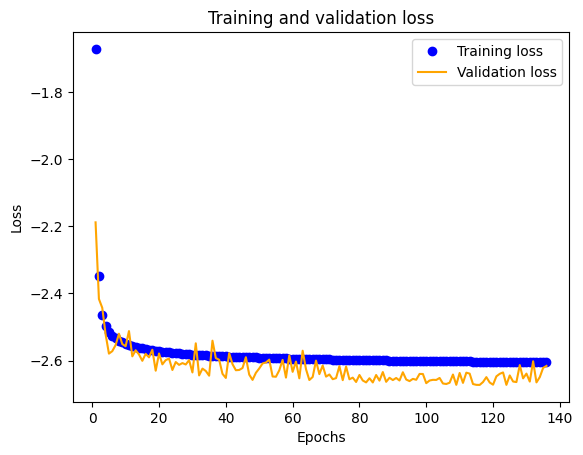

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [11]:
p_test = model.predict(X_test, batch_size= 512)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Btrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

df['mean'] = (df['alpha']/ (df['alpha']+ df['beta']))*(b-a)
df['mode'] = a + ((df['alpha'] - 1.0)/ (df['alpha']+df['beta']-2.0))*(b-a)

df['var'] = (((df['alpha']*df['beta'])*(b-a)**2))/((df['alpha']+df['beta']+1.0)*(df['alpha']+df['beta'])**2)
df['sigma'] = np.sqrt(df['var'])
# dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = df['mean']*pi/2
df['mode'] = df['mode']*pi/2
df['sigma'] = df['sigma']*pi/2

# df.to_csv("test_1DcotABeta.csv",header=False,index=False)

 46/246 [====>.........................] - ETA: 0s

2023-02-16 16:02:59.858283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 1s 2ms/step


In [12]:
residuals = df['Btrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.006751200714774949 0.030034896176307738


/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_7520/162544794.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


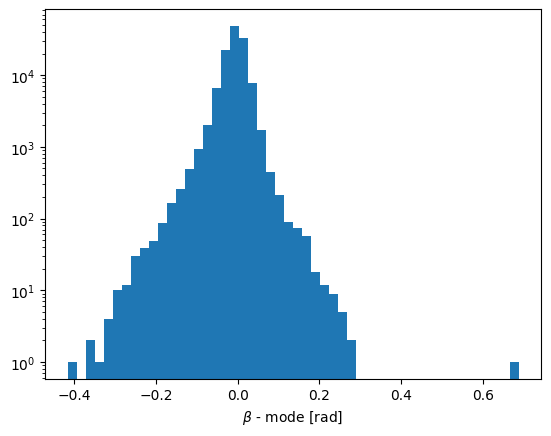

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_7520/162544794.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


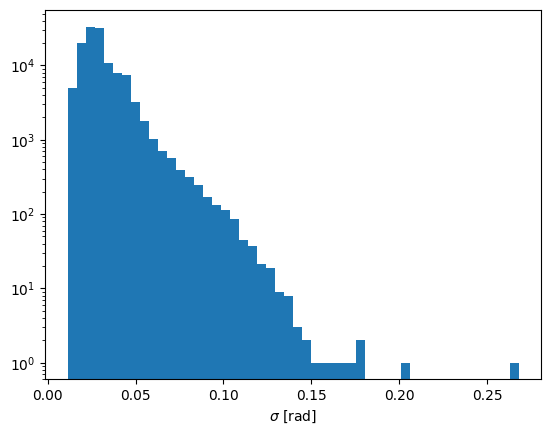

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_7520/162544794.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


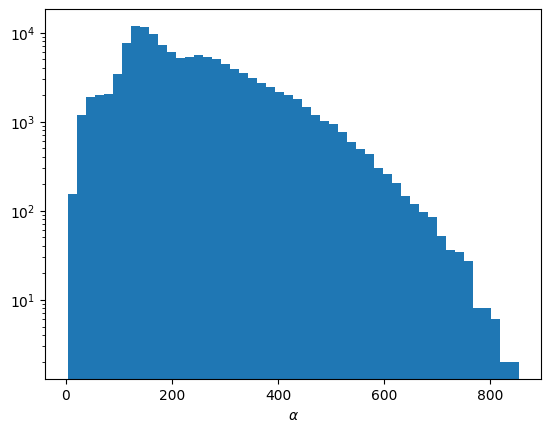

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_7520/162544794.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


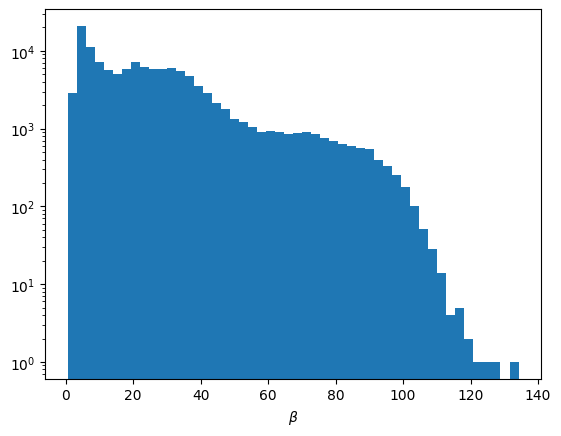

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

Text(0, 0.5, 'log(beta)')

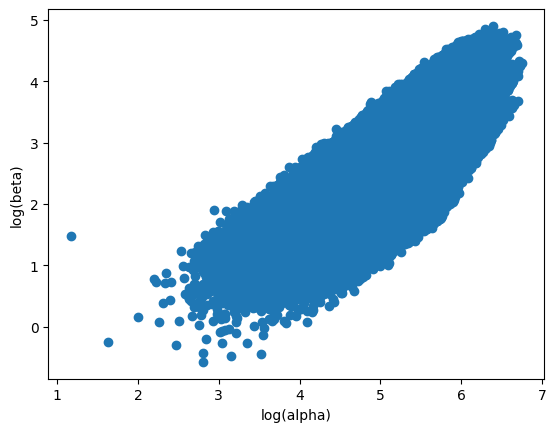

In [14]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

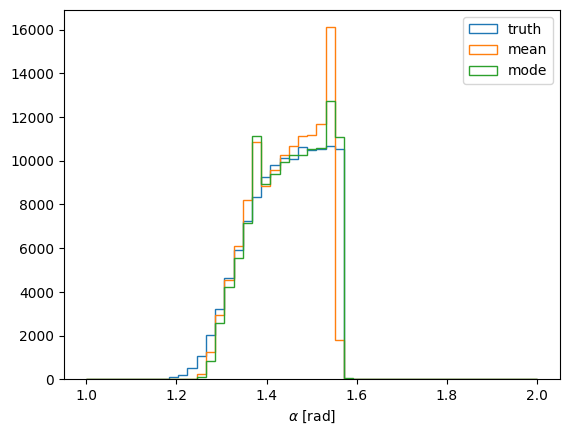

In [15]:
plt.hist(df['Btrue'],bins=np.linspace(1,2,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(1,2,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(1,2,50),histtype='step',label='mode')
# plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
# plt.xlim([0.0,pi])
plt.legend()
plt.show()

Text(0, 0.5, '$\\alpha$ - mode [rad]')

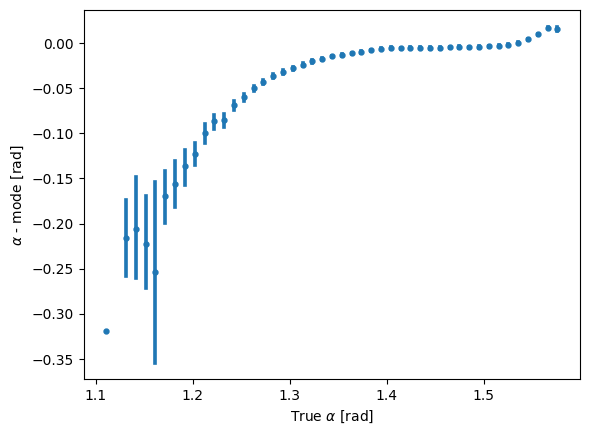

In [16]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [rad]')
plt.ylabel(r'$\alpha$ - mode [rad]')

Text(0, 0.5, '$\\sigma$ [rad]')

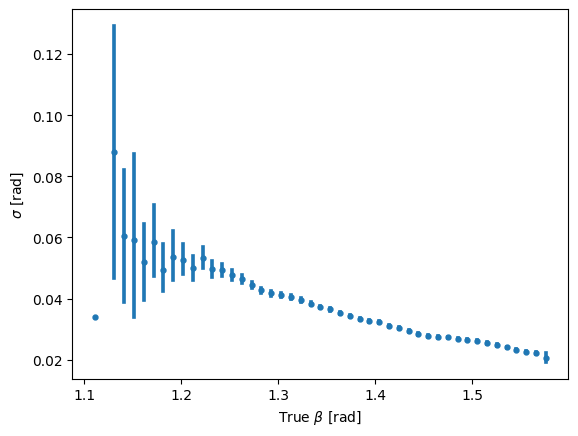

In [17]:
y = sns.regplot(x=df['Btrue'], y=df['sigma'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

-0.20906218117415706 0.9143511482381005


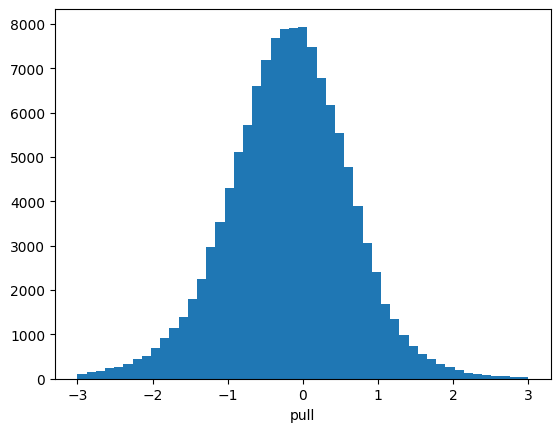

In [18]:
pulls = residuals/df['sigma']
print(np.mean(pulls),np.std(pulls))
plt.hist(pulls,bins=np.linspace(-3,3,50));
plt.xlabel('pull')
plt.show()